In [2]:
import torch
import os
import time
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import sys
yolov5_path = "./yolov5"
if yolov5_path not in sys.path:
    sys.path.append(yolov5_path)
from yolov5.utils.loss import ComputeLoss
from yolov5.models.yolo import Model
import yaml
import zipfile
import requests
os.environ["KAGGLE_KEY"] = "ankitht"
os.environ["KAGGLE_USERNAME"] = "dde58a57a33baa717acaea4fe7fc203"
import kaggle

torch.set_printoptions(sci_mode=False)

train = False #Controls whether we train a model from scratch or use model stored in "checkpoint.pt"


In [3]:

dataset_name = "farzadnekouei/top-view-vehicle-detection-image-dataset"

kaggle.api.dataset_download_files(dataset_name,path=".")
with zipfile.ZipFile("top-view-vehicle-detection-image-dataset.zip") as zf:
        zf.extractall(".")

Dataset URL: https://www.kaggle.com/datasets/farzadnekouei/top-view-vehicle-detection-image-dataset


In [7]:
#Load model

# Download the YOLOv5s weights using torch.hub


#Set which model you want to use here
model_name = "yolov5n.pt"
model_structure = "modified_yolov5n.yaml"
url = f"https://github.com/ultralytics/yolov5/releases/download/v7.0/{model_name}"

if not os.path.exists(model_name):
    response = requests.get(url,stream=True)
    with open(model_name,"wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    

In [4]:
class VehicleDataset(Dataset):
    def __init__(self,image_dir,label_dir,transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform

        self.image_files = sorted(os.listdir(image_dir))
        self.label_files = sorted(os.listdir(label_dir))
    
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.image_dir, self.image_files[idx]))
        #Convert color to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        label_path = os.path.join(self.label_dir,self.label_files[idx])

        with open(label_path,"r") as f:
            label_data = f.readlines()

        boxes = []

        for line in label_data:
            split_line = line.strip().split()
            class_id = int(split_line[0])
            x_center, y_center, width, height = map(float, split_line[1:])
            boxes.append([class_id,x_center,y_center,width,height])
        boxes = torch.tensor(boxes,dtype=torch.float32)
        return image, boxes

def display_sample(image, boxes):
    #Displays sample image from dataset
    image = image.permute(1,2,0).numpy()
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    h,w, c = image.shape

    for box in boxes:
        class_id, x_center, y_center, width, height = box

        x_center *= w
        y_center *= h
        width *= w
        height *= h
        #Top left corner
        x = x_center - width / 2
        y = y_center - height / 2
        rectangle = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor="g",facecolor="none")
        ax.add_patch(rectangle)
    plt.show()

def collate(batch):
    images = torch.stack([item[0] for item in batch],dim=0)
    targets = [item[1] for item in batch]
    return images, targets

train_images = "Vehicle_Detection_Image_Dataset/train/images"

train_labels = "Vehicle_Detection_Image_Dataset/train/labels"

valid_images = "Vehicle_Detection_Image_Dataset/valid/images"

valid_labels = "Vehicle_Detection_Image_Dataset/valid/labels"
        

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((640,640)),
    transforms.ColorJitter(brightness=.4,contrast=.4,saturation=.4,hue=.4),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor()

])



train_dataset = VehicleDataset(train_images,train_labels,transform)
train_dataloader = DataLoader(train_dataset,batch_size=20,shuffle=True,collate_fn=collate)

valid_dataset = VehicleDataset(valid_images,valid_labels,transform)
valid_dataloader = DataLoader(valid_dataset,batch_size=20,collate_fn=collate)


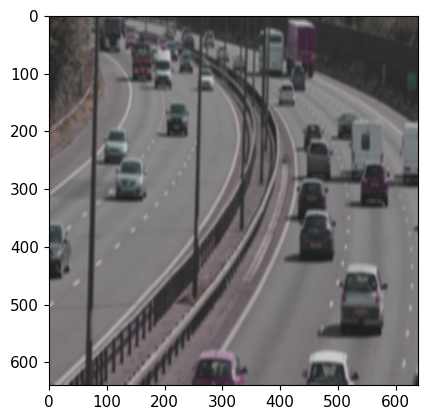

In [5]:
#Example image
%matplotlib inline

display_sample(train_dataset[5][0],[])#train_dataset[5][1])

In [8]:


model = Model(model_structure,ch=3,nc=1)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(device)



                 from  n    params  module                                  arguments                     
  0                -1  1      1760  models.common.Conv                      [3, 16, 6, 2, 2]              
  1                -1  1      4672  models.common.Conv                      [16, 32, 3, 2]                
  2                -1  1      4800  models.common.C3                        [32, 32, 1]                   
  3                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  4                -1  2     29184  models.common.C3                        [64, 64, 2]                   
  5                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  6                -1  3    156928  models.common.C3                        [128, 128, 3]                 
  7                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  8                -1  1    296448  

cuda


In [9]:
#Any box with a confidence below conf_thresh is assumed to not be detected, and box with more than a iou_thresh overlap are combined.

from torchvision.ops import nms

def process_predictions(preds, conf_thresh = .5, iou_thresh = .3):

    formatted_predictions = []
    for pred in preds:
        pred  = pred[pred[:,4] >= conf_thresh]
        boxes = pred[:, :4]  # Transfer to CPU for NMS
        x_center, y_center, width, height = boxes[:,0].squeeze(),boxes[:,1].squeeze(),boxes[:,2].squeeze(),boxes[:,3].squeeze()
        #x_min, y_min, width, height = bo

        x_max = x_center + width / 2
        y_max = y_center + height / 2
        boxes  = torch.stack((x_center,y_center,x_max,y_max),dim=-1).to("cpu")
        if boxes.ndim == 1:
            boxes = boxes.unsqueeze(dim=0)
        #convert to x_min, y_min, x_max, y_max

        scores = pred[:, 4].to("cpu")  # Transfer to CPU for NMS
        labels = pred[:, 5].int().to("cpu")  # Transfer to CPU for NMS

        #Apply confidence threshold first.

        mask = nms(boxes, scores, iou_thresh) #May not have correct input, but that doesn't really matter
        #Need to make nms faster
        boxes, scores, labels = boxes[mask], scores[mask], labels[mask]

        # Perform NMS on CPU
        #convert boxes to format (x1, y1, x2, y2), x1 < x2, y1 , y2
        # Transfer back to GPU if needed
        boxes, scores, labels = boxes.to(device), scores.to(device), labels.to(device)
        formatted_predictions.append({"boxes":boxes,"scores":scores,"labels":labels})
    return formatted_predictions
    
def process_targets(targets):
    h = w = 640
    processed_targets = []
    for target in targets:
        boxes = target[:,1:]
        x_center, y_center, width, height = boxes[:,0].squeeze(),boxes[:,1].squeeze(),boxes[:,2].squeeze(),boxes[:,3].squeeze()
        x_center *= w
        y_center *= h
        width *= w
        height *= h
        x_max = x_center + width / 2
        y_max = y_center + height / 2
        boxes  = torch.stack((x_center,y_center,x_max,y_max),dim=-1)
        if boxes.ndim != 2: #In case only one target
            boxes = boxes.unsqueeze(dim=0)
        labels = target[:,0].int()
        processed_targets.append({"boxes":boxes,"labels":labels})
    return processed_targets

def process_targets_for_loss(labels):
    targets = []
    for i, label in enumerate(labels):
            label = label.to(device)
            img_ids = torch.full((label.size(0), 1), i, dtype=torch.float32, device=device)
            target = torch.cat((img_ids, label), dim=1)
            targets.append(target)
    targets = torch.cat(targets, dim=0)
    return targets
def visualize_single_prediction(image, prediction, target):
    """
    Visualize a single image with ground truth and predicted bounding boxes and labels.

    Args:
    - image (Tensor): The image tensor of shape (3, H, W).
    - prediction (dict): Dictionary containing 'boxes', 'scores', and 'labels' for predictions.
    - target (dict): Dictionary containing 'boxes' and 'labels' for ground truth.
    """
    # Convert image to HWC format for plotting
    image = image.permute(1, 2, 0).cpu().numpy()
    pred_boxes = prediction['boxes'].cpu().numpy()
    pred_labels = prediction['labels'].cpu().numpy()
    pred_scores = prediction['scores'].cpu().numpy()
    gt_boxes = target['boxes'].cpu().numpy()
    gt_labels = target['labels'].cpu().numpy()
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image)

    # Plot ground truth boxes (green)
    h,w, c = image.shape
    
    for box,label in zip(gt_boxes,gt_labels):
        x_center, y_center, x_max, y_max = box #Something wrong with max maybe
        width = (x_max - x_center) * 2
        height = (y_max - y_center) * 2
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        #Represents bottom left
        rectangle = patches.Rectangle((x_min,y_min),width,height,linewidth=2,edgecolor="g",facecolor="none")
        ax.add_patch(rectangle)
    # Plot predicted boxes (red)
    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        x_center, y_center, x_max, y_max = box #Something wrong with max maybe
        width = (x_max - x_center) * 2
        height = (y_max - y_center) * 2
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        #Represents bottom left, the origin is bottom left as well.
        rect = patches.Rectangle((x_min, y_min),width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_center, y_center, f'Pred: {label} ({score:.2f})', color='r', fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

## Test model on a single image, just to make sure i'm properly visualizing boxes and stuff while training

In [13]:
if train:
    pre_trained = torch.load(model_name,map_location=device) #make sure to download the right

    state_dict  = pre_trained["model"].state_dict()

    model_state_dict = model.state_dict()

    pretrained_dict = {k: v for k, v in state_dict.items() if k in model_state_dict and model_state_dict[k].shape == v.shape}
    model_state_dict.update(pretrained_dict)
    model.load_state_dict(model_state_dict)
else:
    state_dict = torch.load(f"checkpoint_{model_name}.pt")
    model.load_state_dict(state_dict)

with open("yolov5/data/hyps/hyp.scratch-med.yaml") as f:
    hyp = yaml.safe_load(f)
model.hyp = hyp

In [10]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = ComputeLoss(model)
#Loss returned is average loss per batch
metric = MeanAveragePrecision()

losses= []
test_losses = []
test_mAP = []
train_mAP = []
# Training loop
num_epochs = 20

%matplotlib inline

if not train:
    num_epochs = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    metric.reset()
    batch_num = 0
    for images, labels in train_dataloader:
        model.train()
        # Move data to the device
        images = images.to(device)
        labels = [label.to(device) for label in labels]
        targets = process_targets_for_loss(labels)
        # Forward pass
        outputs = model(images)
        # Compute loss
        loss, loss_items = loss_fn(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        #Compute train mAP, only for first 5 batches i guess, also how did the whole thing get so slow.
        if batch_num <= 10:
            with torch.inference_mode():
                model.eval()
                eval_outputs = model(images)
                metric_targets = process_targets(labels) #Targets used for mAP ->But are labels set up in the right way? May not be properly ordered
                metric_predicts = process_predictions(eval_outputs[0])
                metric.update(metric_predicts,metric_targets)
        batch_num += 1
            
    avg_loss = running_loss / (len(train_dataset)/ len(train_dataloader))
    mAP = metric.compute()
    train_mAP.append(mAP)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train mAP: {mAP['map']}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss}")
    
    # Validation loop
   
    metric.reset()
    with torch.inference_mode():
        for images, labels in valid_dataloader:
            model.eval()
            images = images.to(device)
            labels = [label.to(device) for label in labels]
            targets = process_targets(labels)
            
            outputs = model(images)
            predicts  = process_predictions(outputs[0]) #Don't need to process all the predicts, only the ones I want to view.
            metric.update(predicts, targets)
            #Compute test loss
            model.train()
            loss_formatted_outputs = model(images)
            loss_formatted_targets = process_targets_for_loss(labels)
            loss, _ = loss_fn(loss_formatted_outputs,loss_formatted_targets) #outputs are probably bad.
            running_loss += loss.item()
            
        
        test_avg_loss = running_loss / (len(valid_dataset) / len(valid_dataloader))
        test_losses.append(test_avg_loss)

        #visualize_single_prediction(images[3],predicts[3],targets[3])

    mAP = metric.compute()
    test_mAP.append(mAP)
    print(f"Epoch [{epoch+1}/{num_epochs}], Test mAP: {mAP['map']}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Test  Loss: {test_avg_loss}")

print("Training complete.")

#I really think i'm incorrectly drawing bounding boxes.
#Why is the visualization not being displayed?


Epoch [1/20], Train mAP: 0.0
Epoch [1/20], Training Loss: 4.103432899090781
Epoch [1/20], Test mAP: 0.029065070673823357
Epoch [1/20], Test  Loss: 4.622128237452772
Epoch [2/20], Train mAP: 0.03604814037680626
Epoch [2/20], Training Loss: 3.229487402670419
Epoch [2/20], Test mAP: 0.05763762816786766
Epoch [2/20], Test  Loss: 3.6945660130845175
Epoch [3/20], Train mAP: 0.11476822942495346
Epoch [3/20], Training Loss: 2.661607754097056
Epoch [3/20], Test mAP: 0.17337502539157867
Epoch [3/20], Test  Loss: 3.1013861464129553
Epoch [4/20], Train mAP: 0.20093394815921783
Epoch [4/20], Training Loss: 2.422542878940924
Epoch [4/20], Test mAP: 0.25293195247650146
Epoch [4/20], Test  Loss: 2.830309435725212
Epoch [5/20], Train mAP: 0.26372355222702026
Epoch [5/20], Training Loss: 2.2566858443306455
Epoch [5/20], Test mAP: 0.26966148614883423
Epoch [5/20], Test  Loss: 2.6444755295912423
Epoch [6/20], Train mAP: 0.30949875712394714
Epoch [6/20], Training Loss: 2.174356023099885
Epoch [6/20], Test 

## Save and load model

In [11]:
if train:
    torch.save(model.state_dict(),f"checkpoint_{model_name}")
    



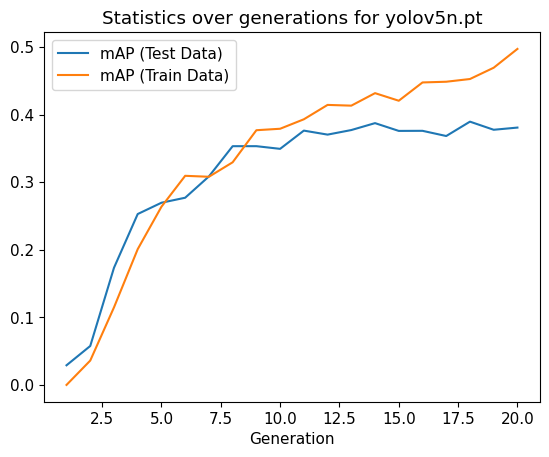

In [ ]:
%matplotlib inline
gen = [i for i in range(1,21)]
plt.plot(gen,[elem["map"].item() for elem in test_mAP],label="mAP (Test Data)")
plt.plot(gen,[elem["map"].item() for elem in train_mAP],label="mAP (Train Data)")


plt.title(f"Statistics over generations for {model_name}")
plt.xlabel("Generation")
plt.legend()
plt.savefig(f"metrics/mAP_{model_name}")

plt.show()

#Plan on adding train mAP as well.

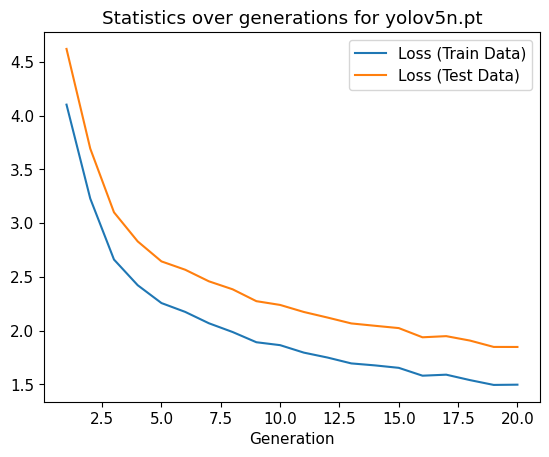

In [13]:
gen = [i for i in range(1,21)]

plt.plot(gen,losses,label="Loss (Train Data)")
plt.plot(gen,test_losses,label="Loss (Test Data)")
plt.title(f"Statistics over generations for {model_name}")
plt.xlabel("Generation")
plt.legend()
plt.savefig(f"metrics/loss_{model_name}.png")
plt.show()


## Latency Tests


### GPU Latency

In [14]:
device = "cuda"

In [14]:
def get_latencies(device,latency_batch_size = 1):

    dummy_input = torch.randn(latency_batch_size,3,640,640).to(device)
    model.to(device)
    model.eval()
    repetitions = 300
    timings = np.zeros((repetitions,1)) #For results

    if device == "cuda":
        starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
        #GPU WARMUP

        with torch.inference_mode():
            for _ in range(10):
                _ = model(dummy_input)
            for rep in range(repetitions):
                starter.record()
                _ = model(dummy_input)
                ender.record()
                torch.cuda.synchronize()
                curr_time = starter.elapsed_time(ender)
                timings[rep] = curr_time
    else:
        for _ in range(10):
            _ = model(dummy_input)

        # Measure Performance
        with torch.inference_mode():
            for rep in range(repetitions):
                start_time = time.time()
                _ = model(dummy_input)
                end_time = time.time()
                
                # Calculate elapsed time in milliseconds
                curr_time = (end_time - start_time) * 1000
                timings[rep] = curr_time
    return timings

timings = get_latencies(device)
mean_syn = np.mean(timings)
standard_dev = np.std(timings)

print(f"Mean Latency: {mean_syn} ms")
print(f"Standard Deviation: {standard_dev} ms")

Mean Latency: 14.06117888768514 ms
Standard Deviation: 1.9246084708267195 ms


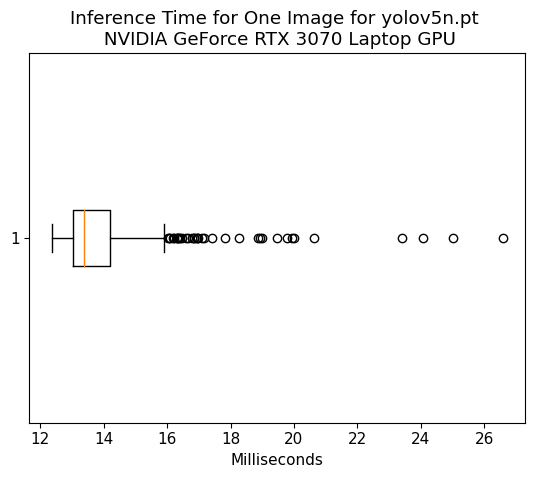

In [16]:
plt.boxplot(timings,vert=False)
device_name = torch.cuda.get_device_name(torch.cuda.current_device()) if device == "cuda" else  "CPU"
plt.title(f"Inference Time for One Image for {model_name} \n {device_name}")
plt.xlabel("Milliseconds")
plt.savefig(f"metrics/latency_{model_name}_{device_name}.png")
plt.show()